<Figure size 432x288 with 0 Axes>

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


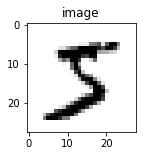

(28, 28)
(1,) [5]


'\ndef train(model):\n    model.train()\n    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode=\'train\'),\n    \t\t\t\t\t\t\t\t\tbatch_size=16,\n                                        shuffle=True)\n    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())\n    EPOCH_NUM = 10\n    for epoch in range(EPOCH_NUM):\n        for batch_id, data in enumerate(train_loader()):\n            images = norm_img(data[0]).astype(\'float32\')\n            labels = data[1].astype(\'float32\')\n\n            predicts = model(images)\n\n            loss = F.square_error_cost(predicts, labels)\n            avg_loss = paddle.mean(loss)\n\n            if batch_id % 1000 == 0:\n                print("epoch_id: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))\n\n            avg_loss.backward()\n            opt.step()\n            opt.clear_grad()\n'

In [2]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F 
import os
import numpy as np 
import matplotlib.pyplot as plt 

train_dataset = paddle.vision.MNIST(mode='train')

train_data0 = np.array(train_dataset[0][0])
train_label_0 = np.array(train_dataset[0][1])
plt.figure("image")
plt.figure(figsize = (2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
plt.axis('on')
plt.title('image')
plt.show()

print(train_data0.shape)
print(train_label_0.shape, train_label_0)

class MINST(paddle.nn.Layer):
    def __init__(self):
        super(MINST, self).__init__()

        self.fc = paddle.nn.Linear(in_features=784, out_features=1)

    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

def norm_img(img):
    assert len(img.shape) == 3
    batch_size, img_h, img_w = img.shape[0], img.shape[1], img.shape[2]
    img = img / 255
    img = paddle.reshape(img, [batch_size, img_h*img_w])
    
    return img

paddle.vision.set_image_backend('cv2')
model = MINST()

'''
def train(model):
    model.train()
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'),
    									batch_size=16,
                                        shuffle=True)
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            images = norm_img(data[0]).astype('float32')
            labels = data[1].astype('float32')

            predicts = model(images)

            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)

            if batch_id % 1000 == 0:
                print("epoch_id: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))

            avg_loss.backward()
            opt.step()
            opt.clear_grad()
'''

#train(model)
#paddle.save(model.state_dict(), './mnist.pdparams')

In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image

def load_image(img_path):
    im = Image.open(img_path).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, -1).astype(np.float32)
    im = 1 - im / 255
    return im

model = MINST()
params_file_path = 'mnist.pdparams'
img_path = './test_3_2.jpg'
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
model.eval()
tensor_img = load_image(img_path)
result = model(paddle.to_tensor(tensor_img))
print('result',result)
print("本次预测的数字是", result.numpy().astype('int32'))

result Tensor(shape=[1, 1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[5.75658274]])
本次预测的数字是 [[5]]


上面的代码抄自PaddlePaddle的官方教程，注释我懒得写了，去官网找吧

这种方式没有经过预处理，直接接入网络，效果实在感人，我写了四个数字，没有一个识别对的，下面分析一下原因。

首先，这个问题并不是一个线性的问题，而我们的网络是一个单层的，也就是线性分类器，我们再用一个线性的东西去拟合一个非线性的，所以效果就会很不好。

下面对解决方案提出一些解决方案的猜想
- 进行预处理，让问题趋近于线性问题
- 增加网络的复杂度，去拟合非线性的问题
- 先提取特征再进行分类

我们先尝试预处理的方案，这里需要在喂数据前进行预处理，我们对训练函数进行修改，并增加预处理函数before_train，需要opencv环境

In [4]:
import cv2

def norm_img_2(img):
    #print(img)
    assert len(img.shape) == 3
    batch_size, img_h, img_w = img.shape[0], img.shape[1], img.shape[2]
    #img.save("mid.jpg")
    #img2 = np.float32(img)
    #print(type(img2))
    #img2 = cv2.imread("mid.jpg")
    img2 = img
    img2 = np.squeeze(img2, 0)
    img2 = np.uint8(img2)
    #print(img2.shape)
    #mid = Image.fromarray(img2)
    #mid.save("mid.png")
    cv2.imwrite("mid.png",img2)
    #img2 = cv2.cvtColor(np.asarray(img2), cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(img2, 230, 255, cv2.THRESH_BINARY_INV)#二值化，黑白反转
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)#找到边界
    x, y, w, h = cv2.boundingRect(contours[0])#获取边界信息
    img = paddle.vision.transforms.crop(img, 26 - y, x, h, w)
    #img = paddle.vision.transforms.to_tensor(img)
    img = paddle.vision.resize(img,(28,28))
    img = img / 255
    img = paddle.reshape(img, [batch_size, img_h*img_w])
    
    return img

def train_2(model):
    model.train()
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'),
    									batch_size=1,
                                        shuffle=True)
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #主要修改这里喂进去的图像
            images = norm_img_2(data[0]).astype('float32')
            labels = data[1].astype('float32')
            predicts = model(images)

            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)

            if batch_id % 10000 == 0:
                print("epoch_id: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))

            avg_loss.backward()
            opt.step()
            opt.clear_grad()

def before_train(image):
    pass

#img = load_image("test_3_2.jpg")
train_2(model)

#train(model)
#paddle.save(model.state_dict(), './mnist.pdparams')

epoch_id: 0, batch_id: 0, loss is: [3.8233187]
epoch_id: 0, batch_id: 1000, loss is: [4.464732]
epoch_id: 0, batch_id: 2000, loss is: [9.15641]
epoch_id: 0, batch_id: 3000, loss is: [13.675595]
epoch_id: 0, batch_id: 4000, loss is: [3.2717824]
epoch_id: 0, batch_id: 5000, loss is: [5.3499722]
epoch_id: 0, batch_id: 6000, loss is: [0.4531188]
epoch_id: 0, batch_id: 7000, loss is: [17.119446]
epoch_id: 0, batch_id: 8000, loss is: [5.171847]
epoch_id: 0, batch_id: 9000, loss is: [13.9322405]
epoch_id: 0, batch_id: 10000, loss is: [8.630498]
epoch_id: 0, batch_id: 11000, loss is: [10.47385]
epoch_id: 0, batch_id: 12000, loss is: [16.082396]
epoch_id: 0, batch_id: 13000, loss is: [2.9939675]
epoch_id: 0, batch_id: 14000, loss is: [23.372213]
epoch_id: 0, batch_id: 15000, loss is: [9.925264]
epoch_id: 0, batch_id: 16000, loss is: [0.73140424]
epoch_id: 0, batch_id: 17000, loss is: [3.57947]
epoch_id: 0, batch_id: 18000, loss is: [3.5038922]
epoch_id: 0, batch_id: 19000, loss is: [14.762081]


In [5]:
import cv2
img = cv2.imread("test_1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print(img)
cv2.imwrite("img.jpg",img)

paddle.save(model.state_dict(), './mnist_2.pdparams')

[[248 247 249 ... 248 248 248]
 [249 248 249 ... 247 247 247]
 [250 248 248 ... 252 252 251]
 ...
 [249 249 250 ... 249 248 247]
 [250 250 250 ... 250 249 248]
 [251 251 251 ... 251 250 250]]


In [12]:
def load_image_2(img_path):
    im = Image.open(img_path).convert('L')
    img2 = im
    img2 = np.squeeze(img2, 0)
    img2 = np.uint8(img2)
    #print(img2.shape)
    #mid = Image.fromarray(img2)
    #mid.save("mid.png")
    cv2.imwrite("mid.png",img2)
    #img2 = cv2.cvtColor(np.asarray(img2), cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(img2, 230, 255, cv2.THRESH_BINARY_INV)#二值化，黑白反转
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)#找到边界
    x, y, w, h = cv2.boundingRect(contours[0])#获取边界信息
    img = paddle.vision.transforms.crop(img, 26 - y, x, h, w)
    #img = paddle.vision.transforms.to_tensor(img)
    #im = paddle.vision.resize(im,(28,28))
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, -1).astype(np.float32)
    im = 1 - im / 255
    return im

model = MINST()
params_file_path = 'mnist_2.pdparams'
img_path = './test_2.jpg'
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
model.eval()
tensor_img = load_image(img_path)
result = model(paddle.to_tensor(tensor_img))
print('result',result)
print("本次预测的数字是", result.numpy().astype('int32'))

result Tensor(shape=[1, 1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [[-2.62990475]])
本次预测的数字是 [[-2]]


增加预处理的结果更加离谱数字是“11“可还行。

分析原因：这是在用一套网络分类10个数字，问题仍然是非线性的，如果只判断是或不是，按照经验应该是线性问题。

试验结果：经过预处理，这个问题仍然是非线性问题。